# DATASET

The dataset is taken from one of the NASA Space Apps Challenge in 2018, “Spot that fire!”, under the section VOLCANOES, ICEBERGS, AND ASTEROIDS (OH MY).
The goal was using the dataset to develop a web-based or phone/tablet-based app that helps engage the public in wildfire prevention and early wildfire detection.
Here in my project I shall use the same dataset to develop a model that can recognize the images with fire.

Data was collected to train a model to distinguish between the images that contain fire (fire images) and regular images (non-fire images), so the whole problem was binary classification.
Data is divided into 2 folders, fire images folder contains 755 outdoor-fire images some of them contains heavy smoke, the other one is non-fire images which contain 244 nature images (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).
Data is skewed, which means the 2 classes (folders) don't have an equal number of samples, so make sure that you have a validation set with an equally-sized number of images per class (eg: 40 images of both fire and non-fire classes).

# METHODOLOGY
1. Data exploration & visualisation
1. Splitting of data
1. Deep Learning Model to Classify the Images
  * CNN
  * CNN with hyper parameter tuning
  * CNN with transferearning-VGG16

# DATA EXPLORATION & VISULISATION

In [1]:
# import required basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
from google.colab import drive
drive.mount('/content/drive')
filename = '/content/drive/My Drive/Imarticus Projects/Capstone Project 2/fire_dataset'

Mounted at /content/drive


In [2]:
import os
cwd= os.getcwd()
print(cwd)

/content


In [3]:
df = pd.DataFrame(columns=['path','label']) # creating empty dataframe

# making all fire images as 1
for dirname, _, filenames in os.walk('/content/drive/My Drive/Imarticus Projects/Capstone Project 2/fire_dataset/fire_images'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

# making all non-fire images as 0
for dirname, _, filenames in os.walk('/content/drive/My Drive/Imarticus Projects/Capstone Project 2/fire_dataset/non_fire_images'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
    
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,/content/drive/My Drive/Imarticus Projects/Cap...,fire
1,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire
2,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire
3,/content/drive/My Drive/Imarticus Projects/Cap...,fire
4,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire
5,/content/drive/My Drive/Imarticus Projects/Cap...,fire
6,/content/drive/My Drive/Imarticus Projects/Cap...,fire
7,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire
8,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire
9,/content/drive/My Drive/Imarticus Projects/Cap...,fire


In [4]:
df.tail()

,path,label
994,/content/drive/My Drive/Imarticus Projects/Cap...,fire
995,/content/drive/My Drive/Imarticus Projects/Cap...,fire
996,/content/drive/My Drive/Imarticus Projects/Cap...,fire
997,/content/drive/My Drive/Imarticus Projects/Cap...,fire
998,/content/drive/My Drive/Imarticus Projects/Cap...,fire


In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

In [6]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])

fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['rosybrown','lightgreen'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(values=df['label'].value_counts().to_numpy(),labels=df['label'].value_counts().index,marker=dict(colors=['rosybrown','lightgreen'])),row=1, col=2)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

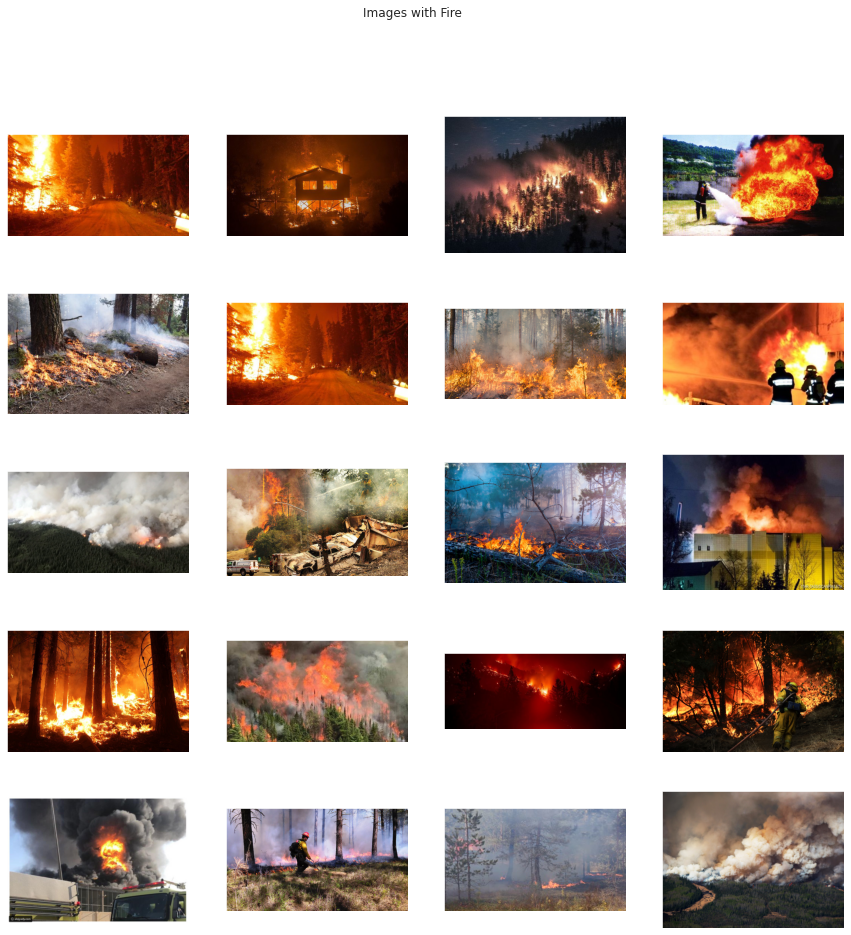

In [8]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')

pics = 20 #set the number of pics
fig,ax = plt.subplots(int(pics//4),4,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//4)*4):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

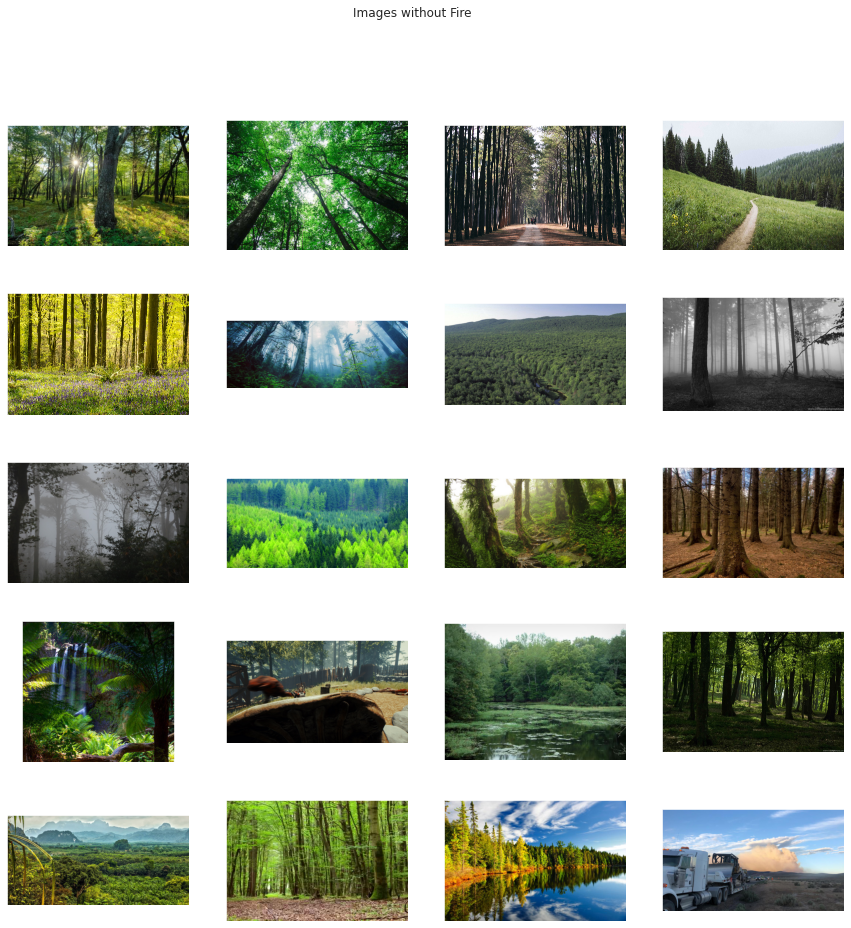

In [9]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')

pics = 20 #set the number of pics
fig,ax = plt.subplots(int(pics//4),4,figsize=(15,15))
plt.suptitle('Images without Fire')
ax = ax.ravel()
for i in range((pics//4)*4):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

Visualizing the size of pictures, since sizes vary as seen above.

In [10]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/drive/My Drive/Imarticus Projects/Cap...,fire,1138,1365
1,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,1136,640
2,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,368,399
3,/content/drive/My Drive/Imarticus Projects/Cap...,fire,422,750
4,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,650,712


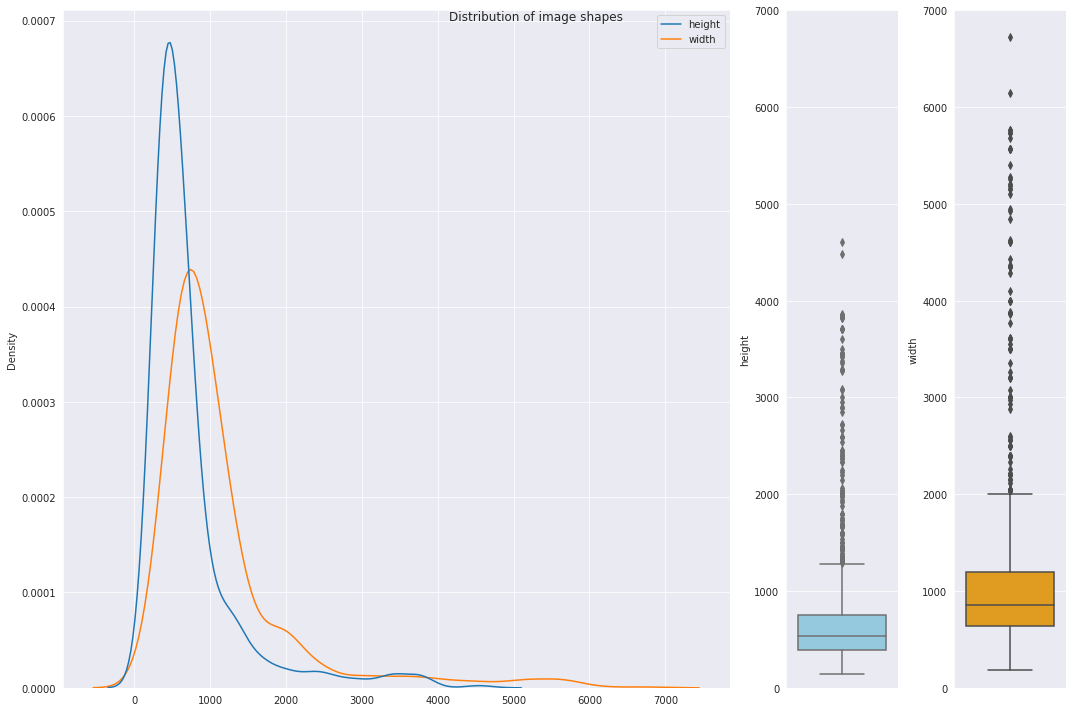

In [11]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

Splitting the datatset into training, validation and testing datasets

In [12]:
df_original = df.copy()
df_original= df_original.drop(['height','width'],axis=1)

In [13]:
# Split into training, test and validation sets
val_index = int(df_original.shape[0]*0.1)

train_df = df_original.iloc[val_index:]

test_df = df_original.iloc[:val_index]

In [14]:
# Display the shapes of the sets
train_df.shape, test_df.shape

((900, 2), (99, 2))

In [15]:
train_df.head()

,path,label
99,/content/drive/My Drive/Imarticus Projects/Cap...,fire
100,/content/drive/My Drive/Imarticus Projects/Cap...,fire
101,/content/drive/My Drive/Imarticus Projects/Cap...,fire
102,/content/drive/My Drive/Imarticus Projects/Cap...,fire
103,/content/drive/My Drive/Imarticus Projects/Cap...,fire


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.1,
)
test_generator=ImageDataGenerator()

In [18]:
train_gen = train_generator.flow_from_dataframe(train_df,x_col='path',y_col='label',images_size=(224,224), batch_size = 32,class_mode='binary',subset='training')
valid_gen = train_generator.flow_from_dataframe(train_df,x_col='path',y_col='label',images_size=(224,224), batch_size = 32,class_mode='binary',subset='validation')
test_gen= test_generator.flow_from_dataframe(test_df,x_col='path',y_col='label',images_size=(224,224), batch_size = 32,class_mode='binary')

Found 810 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.


In [19]:
type(train_gen)

keras.preprocessing.image.DataFrameIterator

In [20]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


In [21]:
class_indices = {}
for key in valid_gen.class_indices.keys():
    class_indices[valid_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


In [22]:
class_indices = {}
for key in test_gen.class_indices.keys():
    class_indices[test_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


So, we have 810 images in training set, 90 in validation set and 99 in testing set

# Image preprocessing using Xception bottleneck Feature Extraction and then Image Classification using Fullyconnected Network

In [23]:
df.head()

,path,label,height,width
0,/content/drive/My Drive/Imarticus Projects/Cap...,fire,1138,1365
1,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,1136,640
2,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,368,399
3,/content/drive/My Drive/Imarticus Projects/Cap...,fire,422,750
4,/content/drive/My Drive/Imarticus Projects/Cap...,non_fire,650,712


In [24]:
df['label'] = df['label'].map({'fire': 0, 'non_fire': 1})

In [25]:
df.tail()

,path,label,height,width
994,/content/drive/My Drive/Imarticus Projects/Cap...,0,275,390
995,/content/drive/My Drive/Imarticus Projects/Cap...,0,562,1000
996,/content/drive/My Drive/Imarticus Projects/Cap...,0,541,1000
997,/content/drive/My Drive/Imarticus Projects/Cap...,0,2000,3000
998,/content/drive/My Drive/Imarticus Projects/Cap...,0,800,1200


In [35]:
df1 = df.copy()
df1= df1.drop(['height','width'],axis=1)
# Split into training, test and validation sets
val_index = int(df1.shape[0]*0.1)

train_df1 = df1.iloc[val_index:]

test_df1 = df1.iloc[:val_index]

In [27]:
import cv2
from keras.applications import xception
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [36]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

#image segmentation function
def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(filename, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


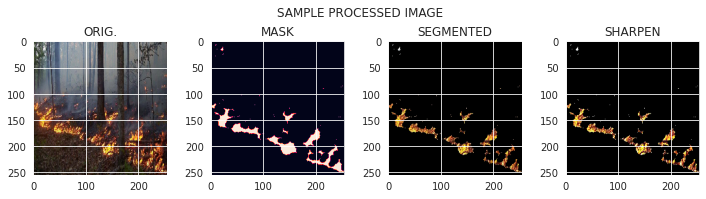

In [37]:
#get an image
img = read_img(train_df1['path'][102],(255,255))
#mask
image_mask = create_mask_for_plant(img)
#segmentation
image_segmented = segment_image(img)
#sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIG.', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)


ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);


In [46]:
INPUT_SIZE=255

##preprocess the input
X_train = np.zeros((len(train_df1), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(train_df1['path'])):
    #read image
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    #masking and segmentation
    image_segmented = segment_image(img)
    #sharpen
    image_sharpen = sharpen_image(image_segmented)
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i] = x

900it [00:35, 25.61it/s]


In [47]:
y = train_df1['label']
train_x, x_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [48]:
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

FIRE IMAGES ON TRAINING DATA:  550
NON-FIRE IMAGES ON TRAINING DATA:  170


In [50]:
##get the features
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_val_x = xception_bf.predict(x_val, batch_size=32, verbose=1)

6/6 [==============================] - 40s 7s/step


In [51]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_val_x.shape)
print('Validation Size: ', bf_val_x.size)

Train Shape:  (720, 2048)
Train Size:  1474560
Validation Shape:  (180, 2048)
Validation Size:  368640


In [60]:
# importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [62]:
#keras Sequential model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               524544    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [63]:
from tensorflow.keras.metrics import Recall,AUC
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [68]:
#train the model @ in solution1
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32,validation_data=(bf_val_x,y_val) )

Epoch 1/100
23/23 [==============================] - 1s 22ms/step - loss: 0.1129 - accuracy: 0.9458 - recall_1: 0.8882 - auc_1: 0.9892 - val_loss: 0.3999 - val_accuracy: 0.8944 - val_recall_1: 0.8776 - val_auc_1: 0.9325
Epoch 2/100
23/23 [==============================] - 0s 17ms/step - loss: 0.0920 - accuracy: 0.9611 - recall_1: 0.9647 - auc_1: 0.9924 - val_loss: 0.4167 - val_accuracy: 0.9111 - val_recall_1: 0.8163 - val_auc_1: 0.9265
Epoch 3/100
23/23 [==============================] - 0s 16ms/step - loss: 0.0964 - accuracy: 0.9583 - recall_1: 0.9294 - auc_1: 0.9910 - val_loss: 0.3951 - val_accuracy: 0.9000 - val_recall_1: 0.8571 - val_auc_1: 0.9341
Epoch 4/100
23/23 [==============================] - 0s 13ms/step - loss: 0.0990 - accuracy: 0.9611 - recall_1: 0.9412 - auc_1: 0.9912 - val_loss: 0.3970 - val_accuracy: 0.8944 - val_recall_1: 0.8776 - val_auc_1: 0.9337
Epoch 5/100
23/23 [==============================] - 0s 9ms/step - loss: 0.0936 - accuracy: 0.9639 - recall_1: 0.9529 - 

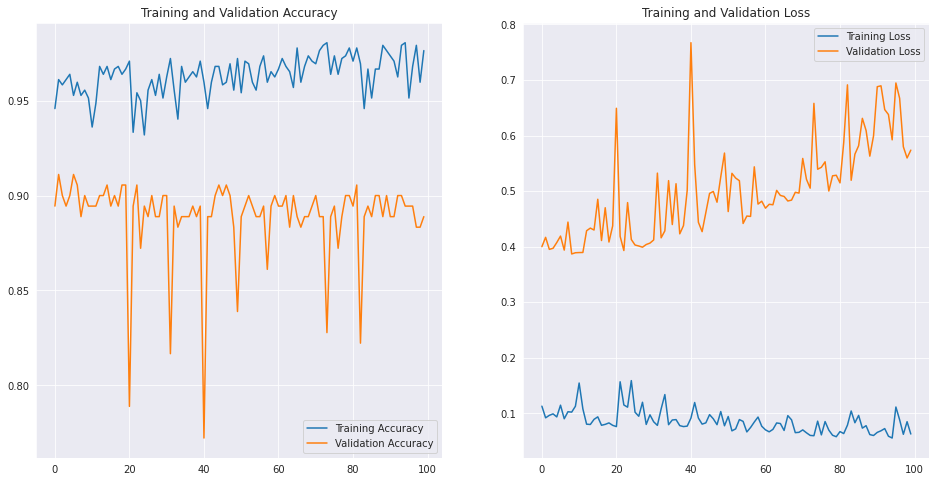

In [83]:
epochs=100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label='Training Accuracy')
plt.plot(epoch_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
#predict the validation data
#predictions = model.predict_classes(bf_train_val)
predictions = (model.predict(bf_val_x) > 0.5).astype("int32")

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       131
           1       0.77      0.84      0.80        49

    accuracy                           0.89       180
   macro avg       0.86      0.87      0.86       180
weighted avg       0.89      0.89      0.89       180

